In [2]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage
import yaml
#from pyevtk.hl import imageToVTK 
from skimage import io
from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage import morphology

# read parameters

In [3]:
with open("../base/parameters.yml") as file:
    parameters = yaml.load(file, Loader=yaml.FullLoader)
with open("../local/parameters.yml") as file:
    parameters_local = yaml.load(file, Loader=yaml.FullLoader)

# overwrite global parameters with local setting
for key in parameters_local:
    parameters[key] = parameters_local[key]
    
print(parameters)

{'data_folder': '/home/ebauman/Data/zebrafish_xenograft/', 'output_folder': '/home/ebauman/Data/zebrafish_xenograft/'}


# specify and read tiff images

In [4]:
#data_folder = parameters["data_folder"]
data_folder = '/home/ebauman/Data/zebrafish_xenograft/03_Processed_Data/3D/'

#filename_short = "200811_Pos002"
#macrophage_file = "200811 mpeg-mCherry x kdrl-lynEYFP LBT123 1in27 GFP 2dpf 1dpi Ti30min_Mark_and_Find003_Position002_macrophages3D.tif"
#im_macrophages = np.array(io.imread(data_folder + macrophage_file))
#tumor_file = "200811 mpeg-mCherry x kdrl-lynEYFP LBT123 1in27 GFP 2dpf 1dpi Ti30min_Mark_and_Find003_Position002_tumor3D.tif"
#im_tumor = np.array(io.imread(data_folder + tumor_file))
#vessel_file = "200811 mpeg-mCherry x kdrl-lynEYFP LBT123 1in27 GFP 2dpf 1dpi Ti30min_Mark_and_Find003_Position002_vessels3D.tif"
#im_vessel = np.array(io.imread(data_folder + vessel_file))

filename = "200804_LBT070_1dpi_Pos001.tif"
filename_short = "200804_Pos001"
im = np.array(io.imread(data_folder + filename))

In [5]:
print(im.shape)

im_tumor = im[:,:,:,:,0]
im_macrophages = im[:,:,:,:,1]
im_vessel = im[:,:,:,:,2]

(33, 128, 1024, 1024, 3)


# smooth images

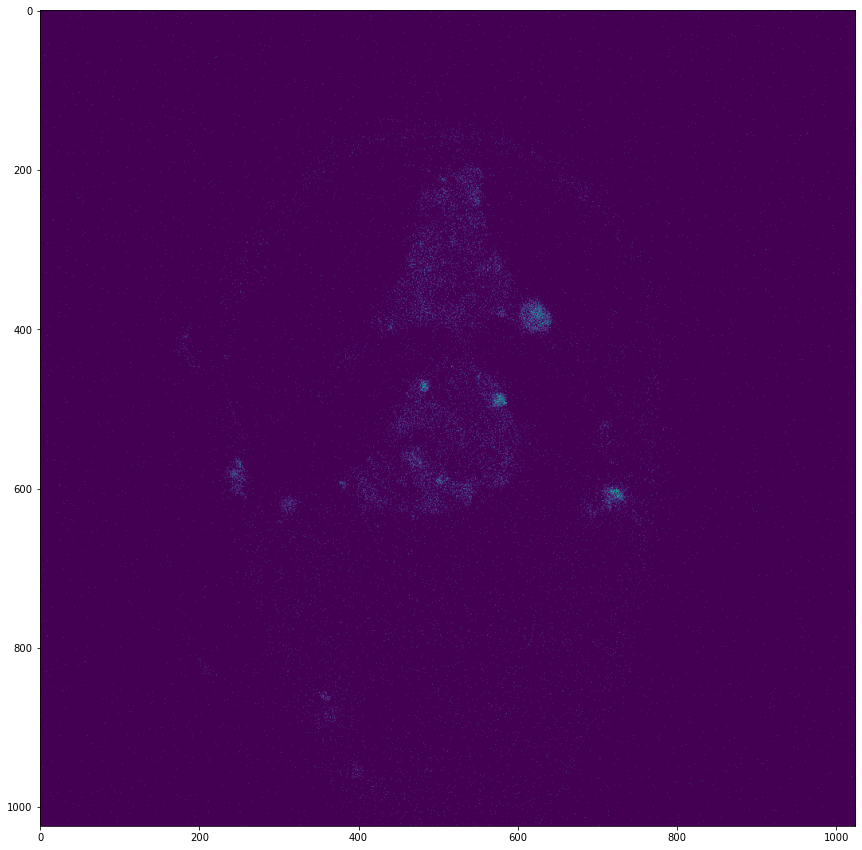

In [32]:
macrophages_example = im_macrophages[0,:,:,:]
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(macrophages_example[50,:,:])
#ax.imshow(np.amax(im_macrophages[0], axis=0))

In [6]:
sigma0 = 5

im_macrophage_smoothed = gaussian_filter(im_macrophages, sigma = sigma0)
#im_tumor_smoothed = gaussian_filter(im_tumor[0,:,:,:], sigma = sigma0)
#im_vessel_smoothed = gaussian_filter(im_vessel[0,:,:,:], sigma = sigma0)

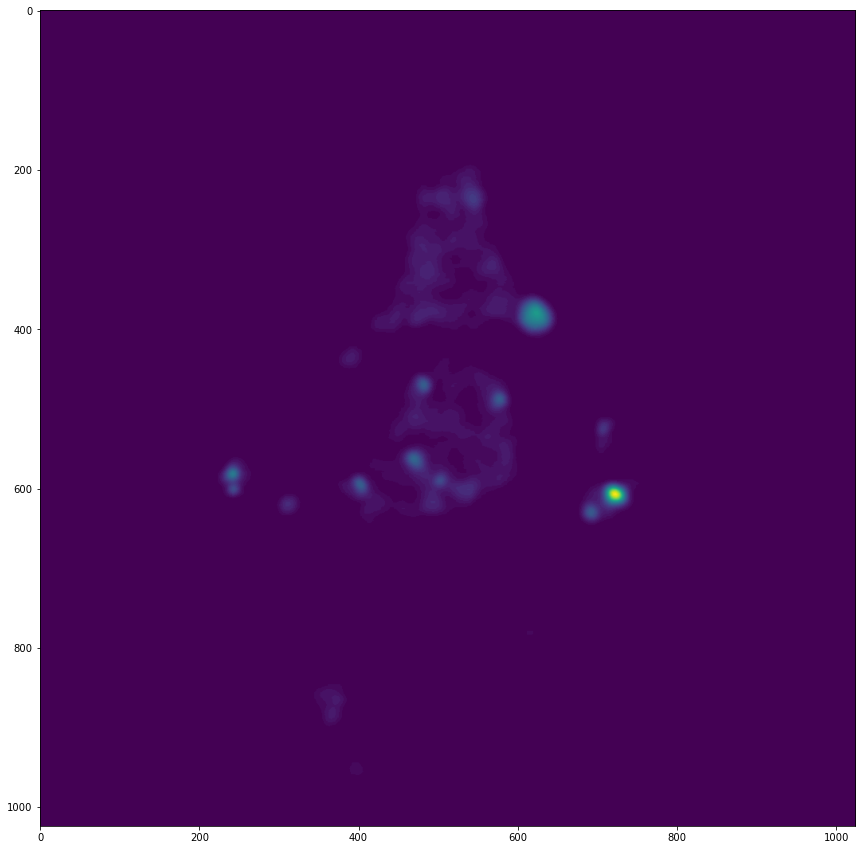

In [33]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(im_macrophage_smoothed[50,:,:])
#ax.imshow(np.amax(im_macrophage_smoothed, axis=0))

# count macrophages

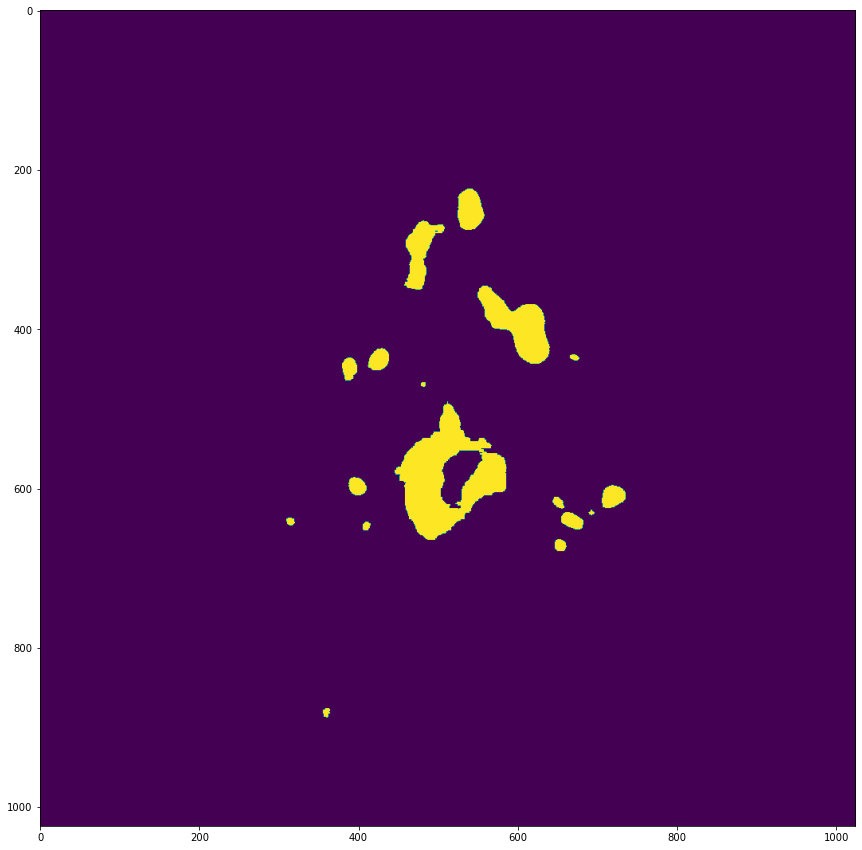

In [8]:
macrophages_mask = np.where(im_macrophage_smoothed > threshold_otsu(im_macrophage_smoothed), True, False)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(macrophages_mask[0,50,:,:])
#ax.imshow(np.amax(macrophages_mask, axis = 0))

In [17]:
# remove artifacts connected to image border
cleared = clear_border(macrophages_mask)
cleared = morphology.remove_small_objects(cleared, 2500, connectivity=2)

# label image regions
label_image = label(cleared)
print("Number of macrophages %s" % np.max(label_image))

Number of macrophages 27


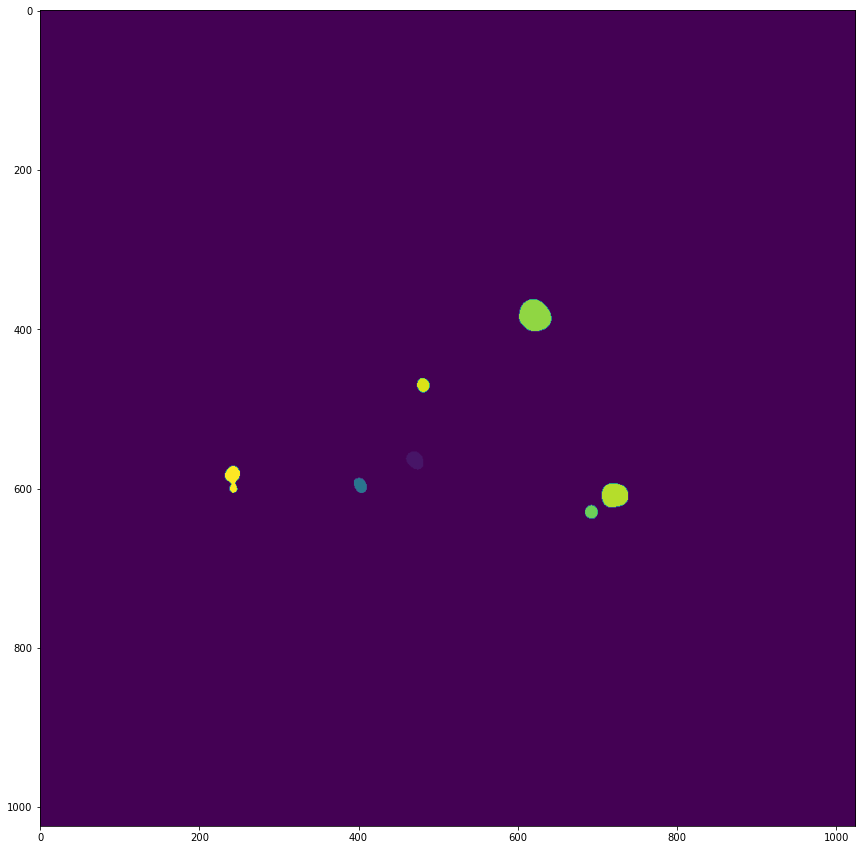

In [34]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(label_image[50,:,:])
#ax.imshow(np.amax(label_image, axis=0))

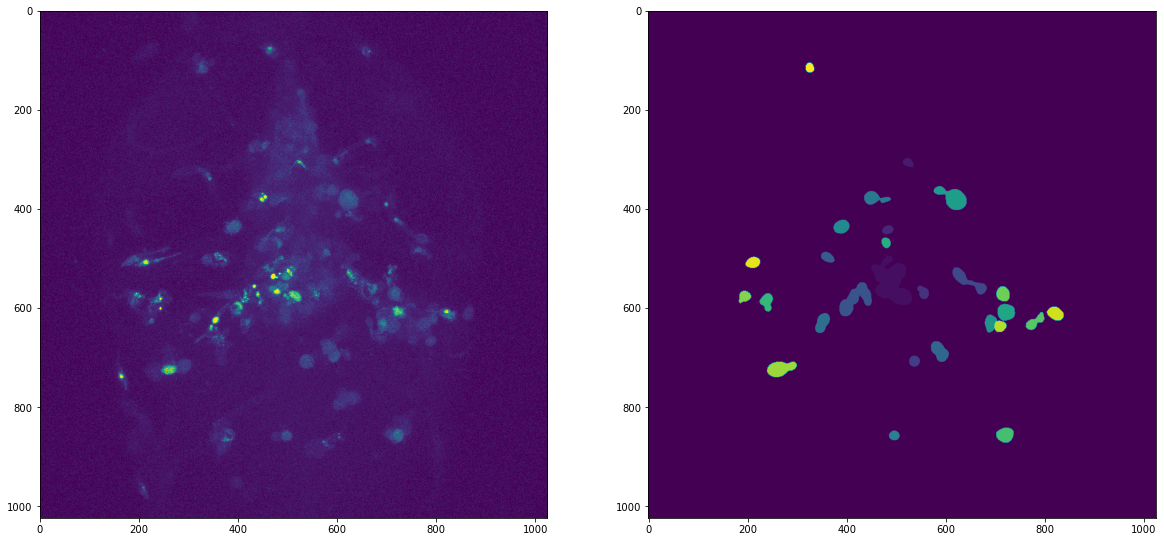

In [37]:
# compare original and mask 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15))
ax1.imshow(np.amax(im_macrophages[0], axis=0))
ax2.imshow(np.amax(label_image, axis=0))

In [ ]:
output_folder = parameters["output_folder"]
    
filename = output_folder + "labeled_macrophages"
imageToVTK(filename, cellData = {"macrophages" : label_image})